In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.SOLPSreader import read_balance

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = read_balance(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spol"], params["Spar"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


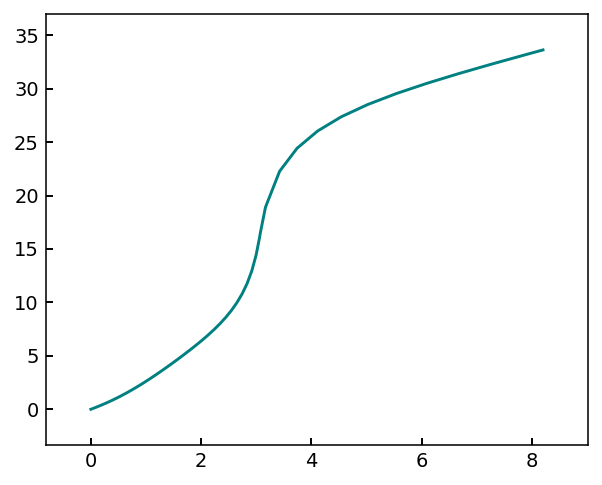

In [6]:
g = eqb_alt["100MW_innerar_midplanepuff"]["outer_lower"][2]

fig, ax = plt.subplots()
ax.plot(g.Spar, g.Spol)

# Prepare cooling curves

In [7]:
curves = {}
T = np.linspace(0, 1000, 1000)

## radas

In [13]:
rd = dict(
    Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc"),
    Ne = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\neon.nc"),
    N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")    
)

for species in rd.keys():
    curves[species] = {}
    ds = rd[species]

    for netau in ds.coords["dim_ne_tau"].values:
        rate = ds["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
        netau_name = netau
        curves[species][netau_name*1e3] = sp.interpolate.interp1d(
            ds.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
            fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
            )
        
curves["Ar"].keys()


dict_keys([1e+18, 5e+18, 1e+19, 5e+19, 1e+20, 5e+20, 1e+21, 5e+21])

## SOLPS

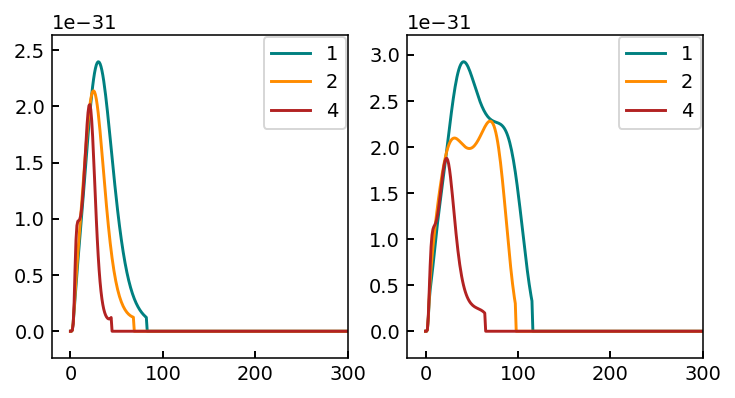

In [9]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()
    ax.set_xlim(-20, 300)


## Custom

In [10]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

In [11]:
curves["Ar"].keys()

dict_keys([np.float64(1e+18), np.float64(1e+19), np.float64(1e+20), np.float64(1e+21), np.float64(1e+22), np.float64(1e+23), np.float64(1e+24), np.float64(1e+25), np.float64(9.999999999999999e+25), np.float64(1e+27)])

C:\Users\mikek\AppData\Local\Temp\ipykernel_4508\753964862.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-10,1000)


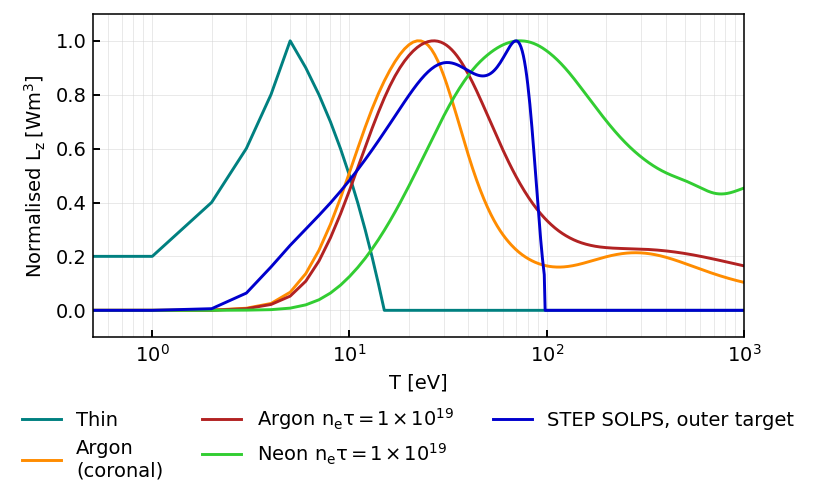

In [15]:
netau = 1e19

curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Nitrogen (coronal)" : curves["N"][5e19],
    "Argon\n(coronal)" : curves["Ar"][5e19],
    r"Argon $n_e \tau = 1\times 10^{19}$" : curves["Ar"][netau],
    r"Neon $n_e \tau = 1\times 10^{19}$" : curves["Ne"][netau],
    "STEP SOLPS, outer target" : curves["extracted_outer"][sepadd_select["outer_lower"]],    
    
    # "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    # "Curve 2" : curves["Ar"][1e16*1e3],
    # "Curve 3" : curves["Ar"][1e14*1e3],
    # "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
}
    
fig, ax = plt.subplots(figsize = (6,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 3, frameon = False)

ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))

ax.set_xscale("log")
ax.set_xlim(-10,1000)

# ax.set_yscale("log")
# ax.set_ylim(1e-3, 1)

ax.grid(which = "both", visible = True)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

# Outer profiles

# DLS run definition

In [16]:
geom = eqb_alt[case]["outer_lower"][0]

inputs = SimulationInputs(
        control_variable="density",
        SparRange = geom.spar_range(mode = "equally_spaced_poloidal", npoints = 30),
        qpllu0=3.5e9,
        nu0=5e19,
        cz0=0.05,
        cooling_curve=curves["set_outer"]["Argon $n_e \\tau = 1\\times 10^{19}$"],
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
        Ctol = 1e-4,
        Ttol = 1e-4
    )

results = dict(
    density = run_dls(dataclasses.replace(inputs, control_variable = "density"), geom, verbosity = 1),
    impurity_frac = run_dls(dataclasses.replace(inputs, control_variable = "impurity_frac"), geom, verbosity = 1),
    power = run_dls(dataclasses.replace(inputs, control_variable = "power"), geom, verbosity = 1)
)


Solving...0.00...0.28...0.52...0.73...0.93...1.11...1.28...1.44...1.60...1.75...1.90...2.04...2.17...2.29...2.40...2.50...2.59...2.66...2.73...2.79...2.84...2.88...2.92...2.95...2.98...3.01...3.02...3.04...3.06...3.08...Complete in 32.3 seconds
Solving...0.00...0.28...0.52...0.73...0.93...1.11...1.28...1.44...1.60...1.75...1.90...2.04...2.17...2.29...2.40...2.50...2.59...2.66...2.73...2.79...2.84...2.88...2.92...2.95...2.98...3.01...3.02...3.04...3.06...3.08...Complete in 33.5 seconds
Solving...0.00...0.28...0.52...0.73...0.93...1.11...1.28...1.44...1.60...1.75...1.90...2.04...2.17...2.29...2.40...2.50...2.59...2.66...2.73...2.79...2.84...2.88...2.92...2.95...2.98...3.01...3.02...3.04...3.06...3.08...Complete in 136.2 seconds


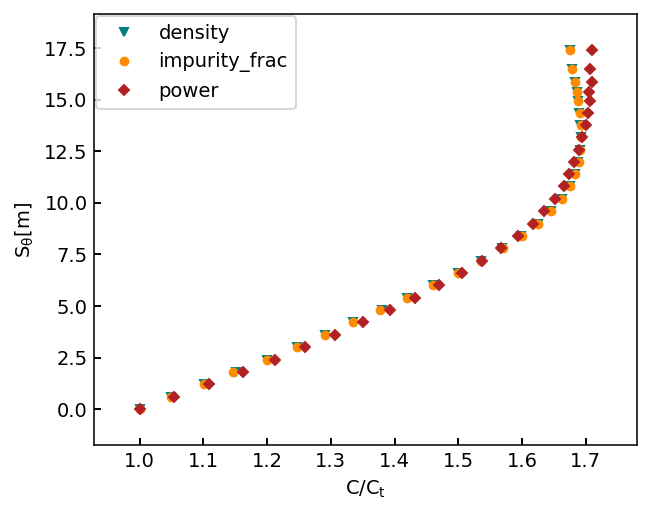

In [ ]:
fig, ax = plt.subplots()

markers = {
    "density" : "v",
    "impurity_frac" : "o",
    "power" : "D"
}

labels = {
    "density" : "Density",
    "impurity_frac" : "Impurity fraction",
    "power" : "Power"
}


for key in results.keys():
    fls = FrontLocationScan(results[key])
    fls.plot_front_movement(ax = ax, label = key, ms = 4, marker = markers[key], lw = 0)
    
ax.legend()
ax.set_ylabel(r"$S_{\theta} [m]$")
ax.set_xlabel("$C/C_t$")
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\ControlVariable.pdf", format = "pdf")